# Optimisation des prix avec l'apprentissage par renforcement (DQN)

## Contexte du projet
Nous voulons trouver la meilleure stratégie de prix pour maximiser les profits d'un produit.  
Le marché est dynamique : les clients réagissent aux prix actuels **et** aux prix passés.  
Les méthodes classiques (prix fixe ou ajustement simple) ne suffisent pas.  
Nous allons utiliser un algorithme de renforcement profond (DQN) pour s’adapter à cet environnement.



In [5]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from qbstyles import mpl_style
mpl_style(dark=False)


## Modélisation du marché : environnement simulé
Nous créons un environnement qui simule la réaction des clients.  
Cet environnement prend en compte :  
- L’effet de mémoire : les prix passés influencent les ventes futures.  
- La réponse asymétrique : baisse et hausse de prix n’ont pas le même effet.  

Cela nous permettra de tester différentes stratégies de prix en toute sécurité.


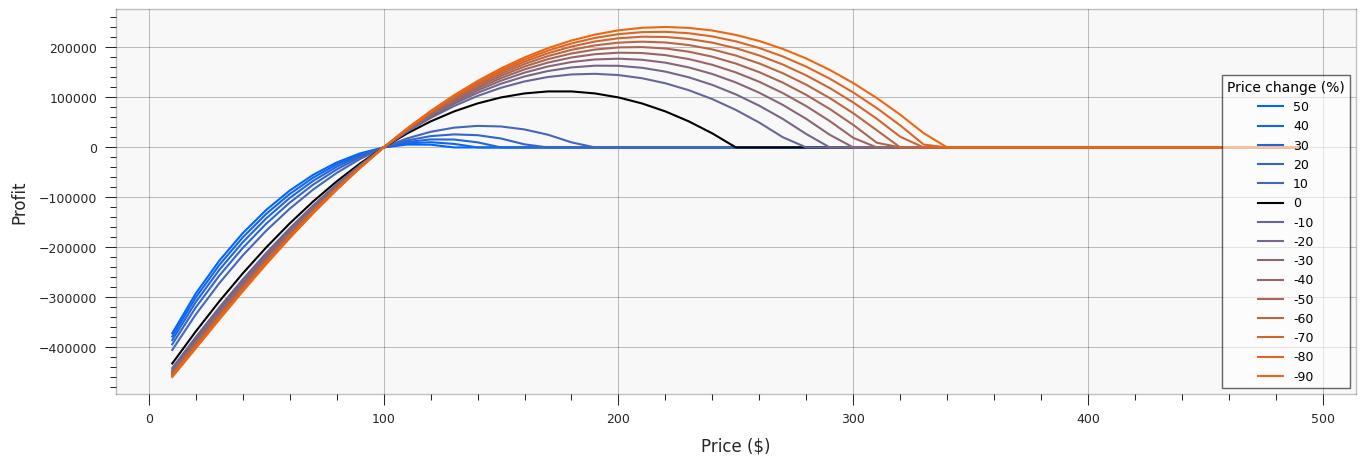

In [6]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'black'
    else:
        p_norm = (price_change_grid[i]-0.5)/1.5
        color = (p_norm, 0.4, 1 - p_norm)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.grid(True)

## Stratégies de base (baselines)
Avant d’utiliser l’algorithme de renforcement, on teste deux stratégies simples :  
1️⃣ **Prix constant optimal** : trouver un prix unique qui maximise le profit moyen.  
2️⃣ **Recherche séquentielle (greedy)** : ajuster le prix à chaque période pour améliorer les profits.

Ces stratégies simples serviront de référence pour comparer l’efficacité de notre DQN.

In [7]:
# Find optimal constant price

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 170, achieved profit is 2352000.0


[170 490 220 190 180 170 490 220 190 180 170 490 220 190 180 170 490 220
 190 180]
Achieved profit is 2903637.2631194014


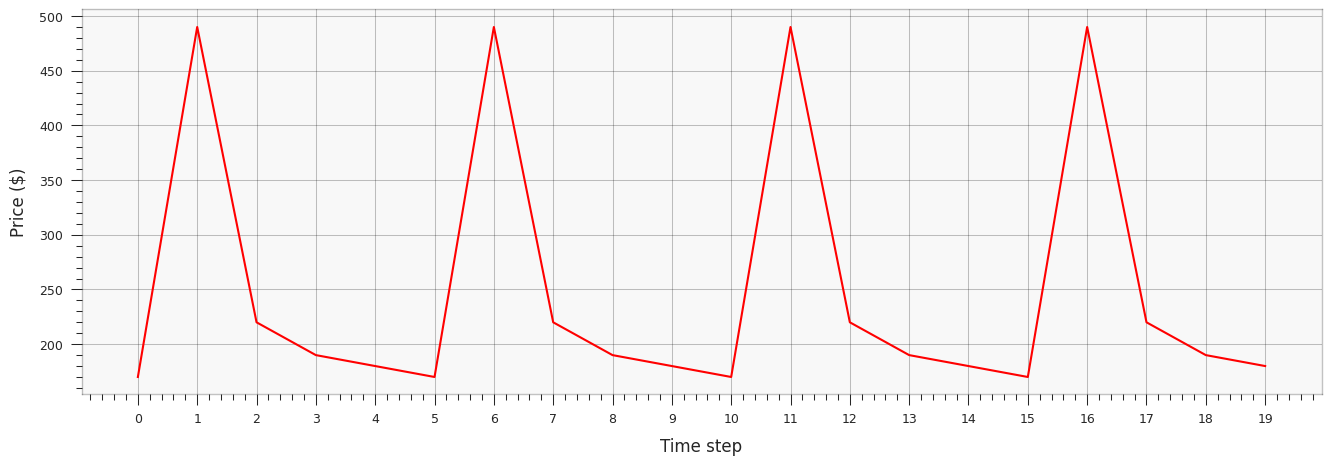

In [8]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    profit_grid = np.array([ profit_response(p) for p in p_grid ])
    return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_grid, t)
    p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')

## Visualisations des résultats
Nous utilisons des graphiques pour comprendre et valider nos résultats :  
- **Courbes de demande et de prix** : pour voir comment les clients réagissent.  
- **Évolution des prix optimaux** : pour les stratégies simples et pour le DQN.  
- **Graphiques des profits** : pour comparer les performances des stratégies.

Ces visualisations sont importantes pour voir si l’algorithme apprend vraiment une bonne stratégie.


Loading BokehJS ...

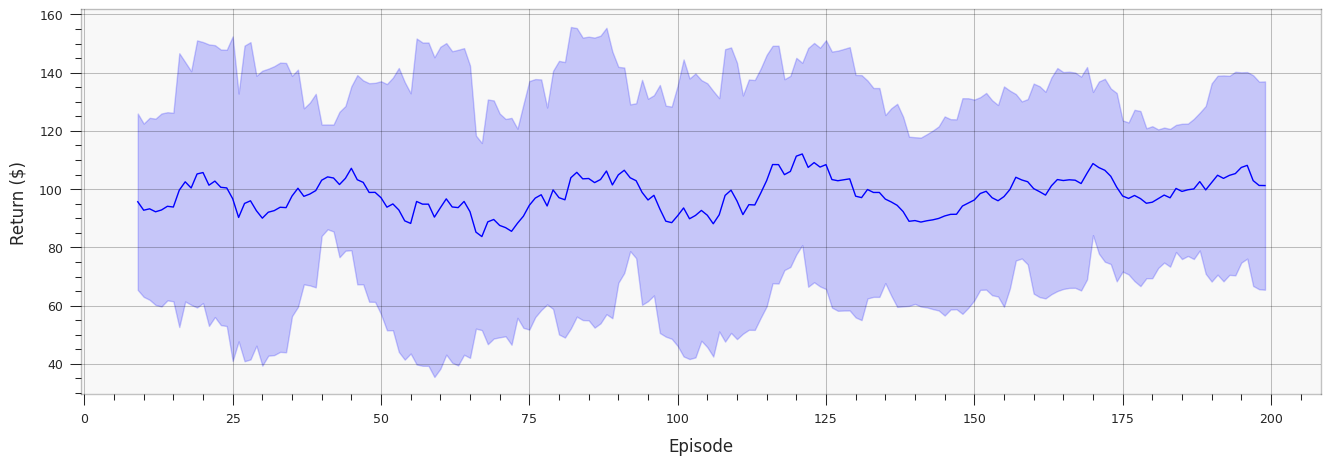

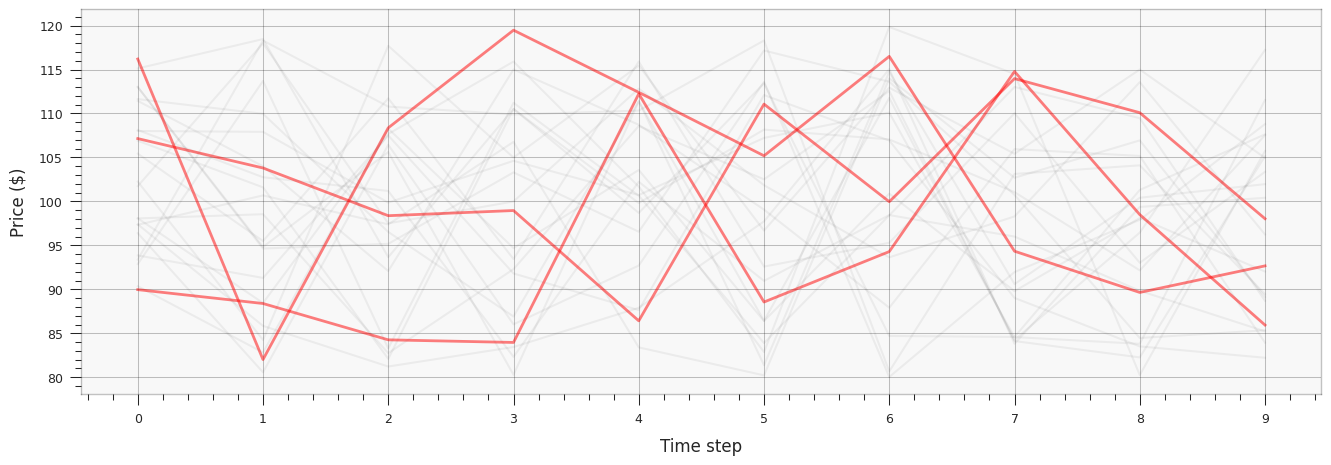

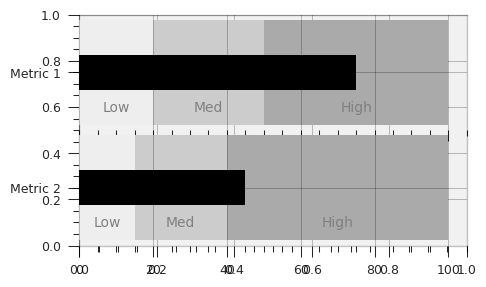

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

# Initialize displays
output_notebook()
%matplotlib inline

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    """Plot rolling mean of returns with standard deviation bands"""
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    
    plt.plot(ma, c='blue', alpha=1.00, linewidth=1)
    plt.fill_between(mstd.index, 
                      ma-range_std*mstd, 
                      ma+range_std*mstd, 
                      color='blue', alpha=0.2)
    plt.grid(True)
    plt.show()

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, T, fig_number=None):
    """Plot price schedules with highlighted recent trajectories"""
    plt.figure(figsize=(16, 5), num=fig_number)
    plt.xlabel("Time step")
    plt.ylabel("Price ($)")
    plt.xticks(range(T))
    
    # Plot all traces (thin lines)
    y_data = np.array(p_trace[0:-1:sampling_ratio])
    if y_data.shape[1] == T:
        y_data = y_data.T  # transpose if needed
    elif y_data.shape[0] == T:
        pass  # already in shape (T, ...)
    else:
        raise ValueError(f"Mismatch: y_data shape {y_data.shape} vs T={T}")
    
    plt.plot(range(T), y_data, c='k', alpha=0.05)
    
    # Highlight recent traces (thick lines)
    y_highlight = np.array(p_trace[-(last_highlights+1):-1])
    if y_highlight.shape[1] == T:
        y_highlight = y_highlight.T
    elif y_highlight.shape[0] == T:
        pass
    else:
        raise ValueError(f"Mismatch: y_highlight shape {y_highlight.shape} vs T={T}")
    
    plt.plot(range(T), y_highlight, c='red', alpha=0.5, linewidth=2)
    plt.grid(True)
    plt.show()

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                  size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    """Create bullet graph visualization"""
    if palette is None:
        palette = ["#eeeeee", "#cccccc", "#aaaaaa"]  # Default grayscale palette
    
    stack_data = np.stack(data[:,2])
    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)
    
    if len(data) == 1:
        axarr = [axarr]  # Ensure axarr is always iterable

    for idx, item in enumerate(data):
        ax = axarr[idx]
        ax.set_aspect('auto')
        ax.set_yticks([0])
        ax.set_yticklabels([item[0]])
        
        # Hide spines
        for spine in ['bottom', 'top', 'right', 'left']:
            ax.spines[spine].set_visible(False)

        # Plot stacked bars
        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([0], lim - prev_limit, 
                    left=prev_limit, 
                    height=h, 
                    color=palette[idx2])
            prev_limit = lim
        
        # Bar for actual value
        ax.barh([0], item[1], height=(h / 3), color=bar_color)

        # Add labels if provided
        if labels is not None:
            for j, rect in enumerate(ax.patches[:-1]):
                width = rect.get_width()
                ax.text(rect.get_x() + width / 2,
                        -h * 0.4,
                        labels[j],
                        ha='center',
                        va='bottom',
                        color=label_color)
                
        if bar_label is not None:
            ax.text(item[1], -h * 0.1, bar_label,
                    ha='left', va='center', color='white')
                
        if axis_label:
            ax.set_xlabel(axis_label)
    
    fig.subplots_adjust(hspace=0)
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Sample data for testing
    returns = np.random.normal(100, 20, 200)
    p_trace = np.random.uniform(80, 120, (100, 10))  # 100 traces of 10 time steps
    bullet_data = np.array([
        ["Metric 1", 75, [20, 30, 50]],
        ["Metric 2", 45, [15, 25, 60]]
    ], dtype=object)
    
    # Plot examples
    plot_return_trace(returns)
    plot_price_schedules(p_trace, sampling_ratio=5, last_highlights=3, T=10)
    bullet_graph(bullet_data, labels=["Low", "Med", "High"])

## Optimisation par DQN (Deep Q-Network)
Le DQN est un algorithme qui apprend en interagissant avec l’environnement.  
Il essaie de maximiser les profits en testant différentes stratégies.  
Il utilise un réseau de neurones pour estimer les meilleurs prix à chaque période.

Le DQN peut s’adapter à un marché dynamique, contrairement aux méthodes simples.

Episode 980/1000 (98.00%)


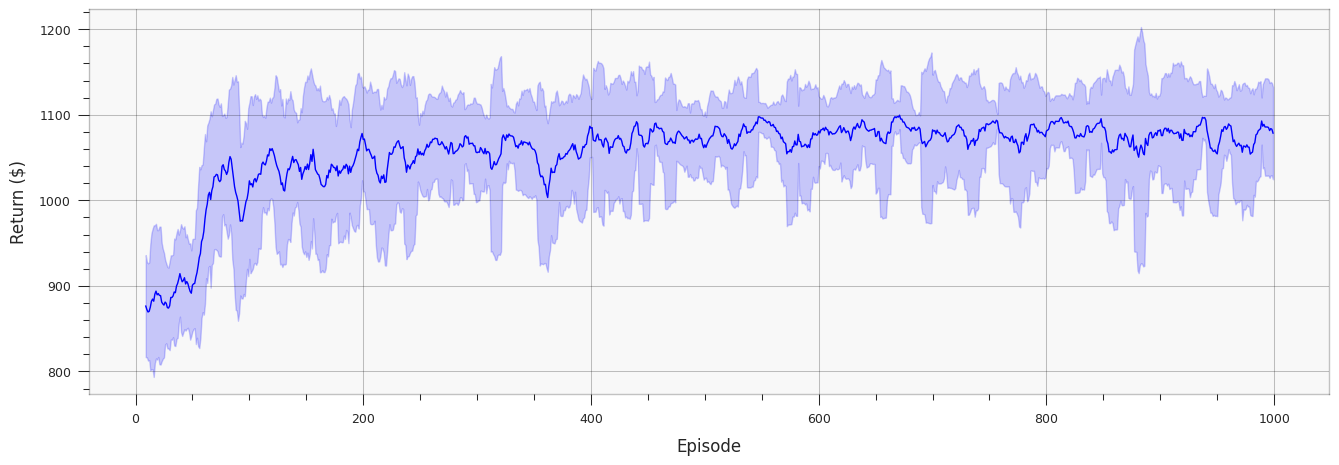

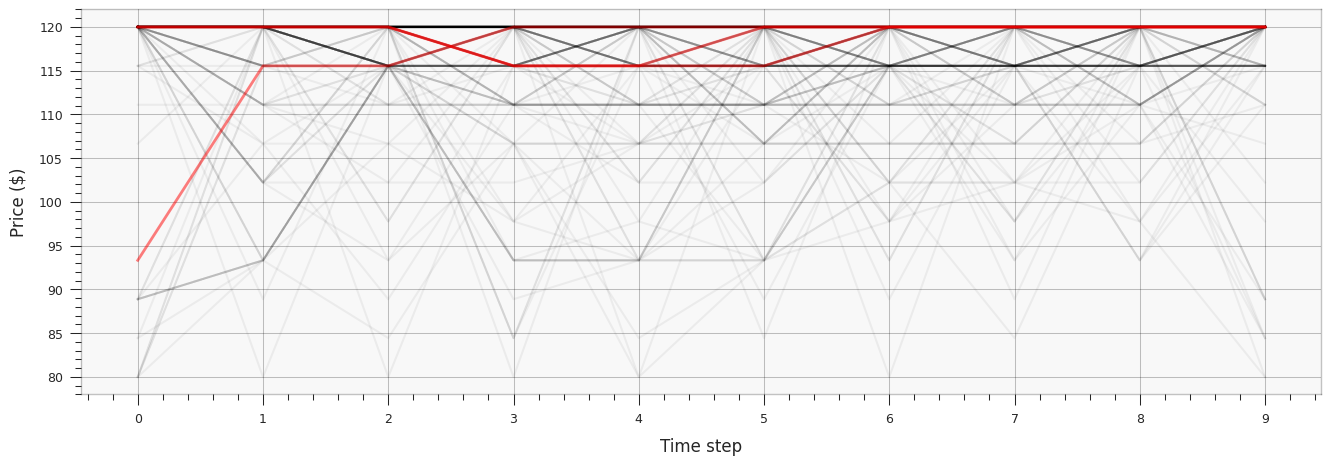

Top 10 episode profits:
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0
Profit: 120.0


In [10]:
# --- Imports ---
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple

# --- Global Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# --- Hyperparameters ---
GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512
T = 10  # number of time steps
price_grid = np.linspace(80, 120, 10)  # example price grid

# --- Utility Functions ---
def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32)).to(device)

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

# --- Environment Functions ---
def profit_t_response(price, prev_prices):
    # Example profit function
    return price - 0.1 * np.sum(np.abs(np.diff(prev_prices)))

def env_initial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.zeros_like(state)
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1:T])
    return next_state, reward

# --- Replay Memory ---
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- DQN Model ---
class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.model(x)

# --- Epsilon-Greedy Policy ---
class AnnealedEpsGreedyPolicy:
    def __init__(self, eps_start=0.9, eps_end=0.05, eps_decay=400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
                         math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

# --- Training update step ---
def update_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), 
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# --- Visualization ---
def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c='blue', linewidth=1)
    plt.fill_between(mstd.index, ma - range_std * mstd, ma + range_std * mstd, color='blue', alpha=0.2)
    plt.grid(True)
    plt.show()

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(figsize=(16, 5), num=fig_number)
    T_local = len(p_trace[0])
    plt.xlabel("Time step")
    plt.ylabel("Price ($)")
    plt.xticks(range(T_local))
    plt.plot(range(T_local), np.array(p_trace[0:-1:sampling_ratio]).T, c='k', alpha=0.05)
    plt.plot(range(T_local), np.array(p_trace[-(last_highlights+1):-1]).T, c='red', alpha=0.5, linewidth=2)
    plt.grid(True)
    plt.show()

# --- Main Training Loop ---
policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = []

for i_episode in range(num_episodes):
    state = env_initial_state()
    reward_trace = []
    p = []

    for t in range(T):
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.cpu().numpy())
        next_state, reward = env_step(t, state, action)
        memory.push(
            to_tensor(state),
            to_tensor_long(action),
            to_tensor(next_state) if t != T - 1 else None,
            to_tensor([reward])
        )
        update_model(memory, policy_net, target_net, optimizer)
        state = next_state
        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        clear_output(wait=True)
        print(f'Episode {i_episode}/{num_episodes} ({i_episode/num_episodes*100:.2f}%)')

# --- Post-training analysis ---
plot_return_trace(return_trace)
fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, sampling_ratio=5, last_highlights=3, fig_number=fig.number)

print("Top 10 episode profits:")
top_profits = sorted([profit_t_response(p[0], p[1:]) for p in p_trace], reverse=True)[:10]
for profit in top_profits:
    print(f'Profit: {profit}')

## Résultats et conclusions
- Le DQN apprend une suite de prix qui maximise les profits totaux.  
- Les performances sont meilleures que les stratégies simples.  
- Le DQN est plus flexible et s’adapte aux changements du marché.

Ces résultats montrent l’intérêt des méthodes de renforcement pour la tarification dynamique.

MovieWriter imagemagick unavailable; using Pillow instead.


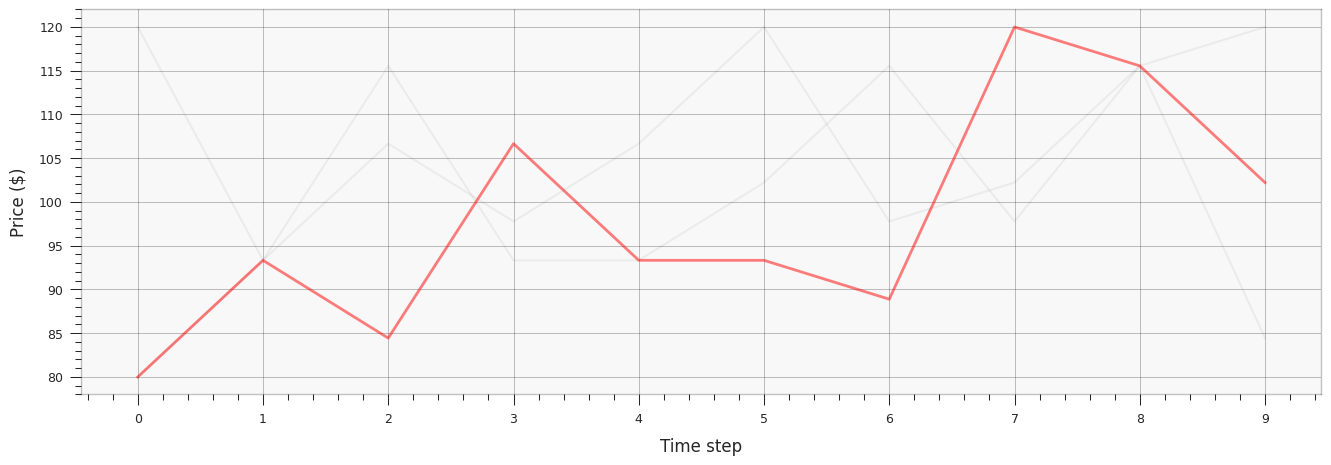

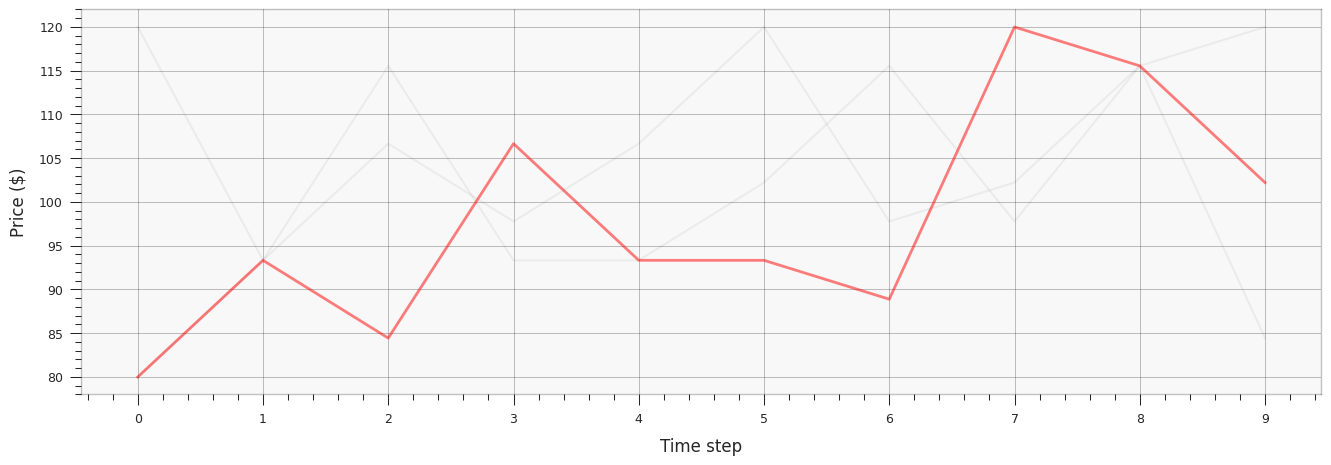

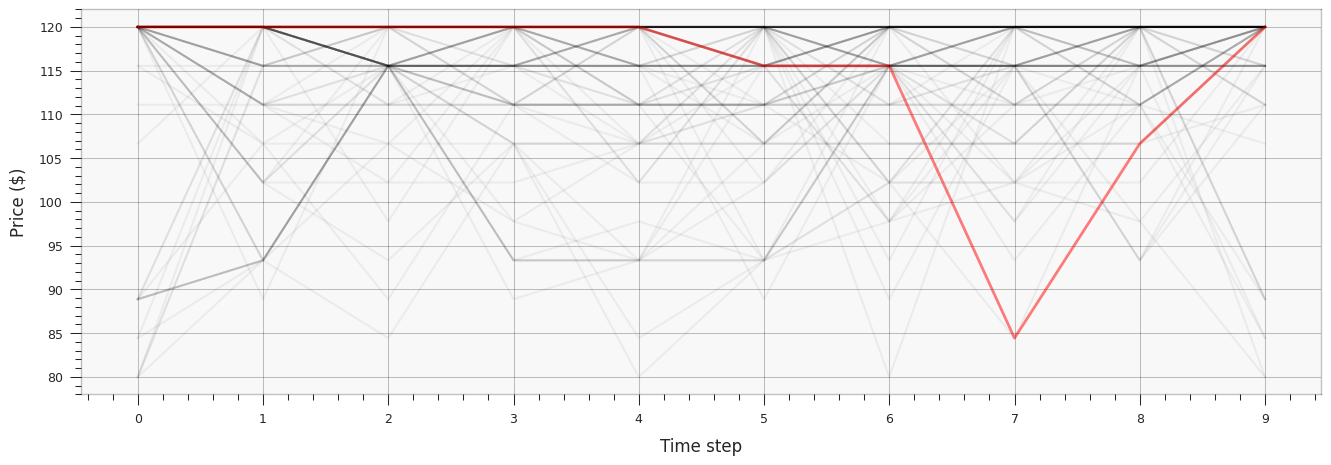

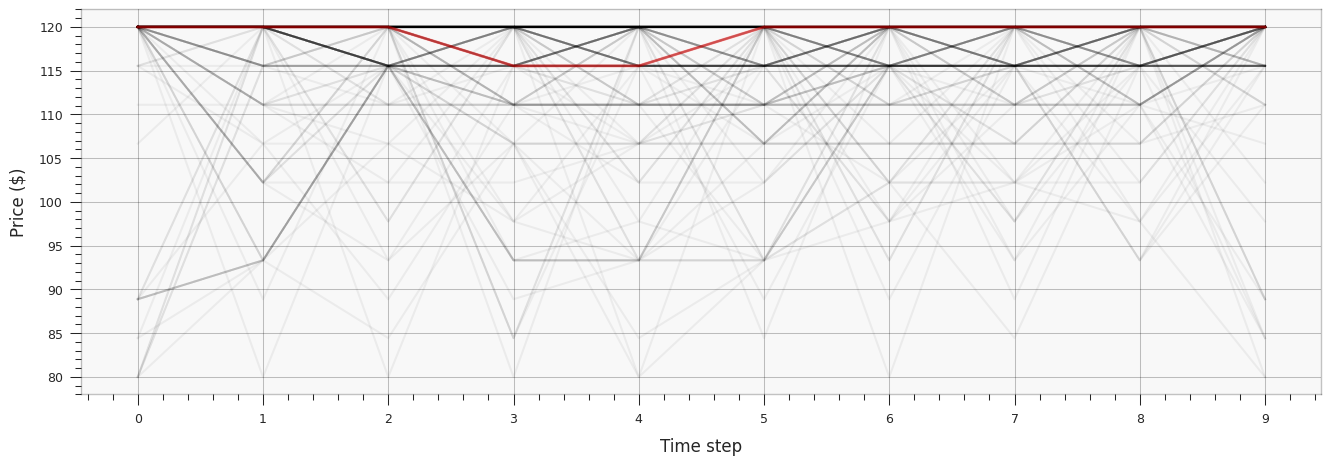

In [13]:
plt.ioff()
fig = plt.figure(figsize=(16, 5))

def animate(t):
    fig.clear()
    plot_price_schedules(p_trace[0:t], 5, 1, fig.number)

# 3 key frames
frames = [10, 500, 999]

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=500, blit=False, repeat_delay=1000)
ani.save('sim.gif', dpi=80, writer='imagemagick', fps=1)  # fps=1 to slow it down to see each frame

from matplotlib import rc
rc('animation', html='jshtml')


Optimal price action: 120.0


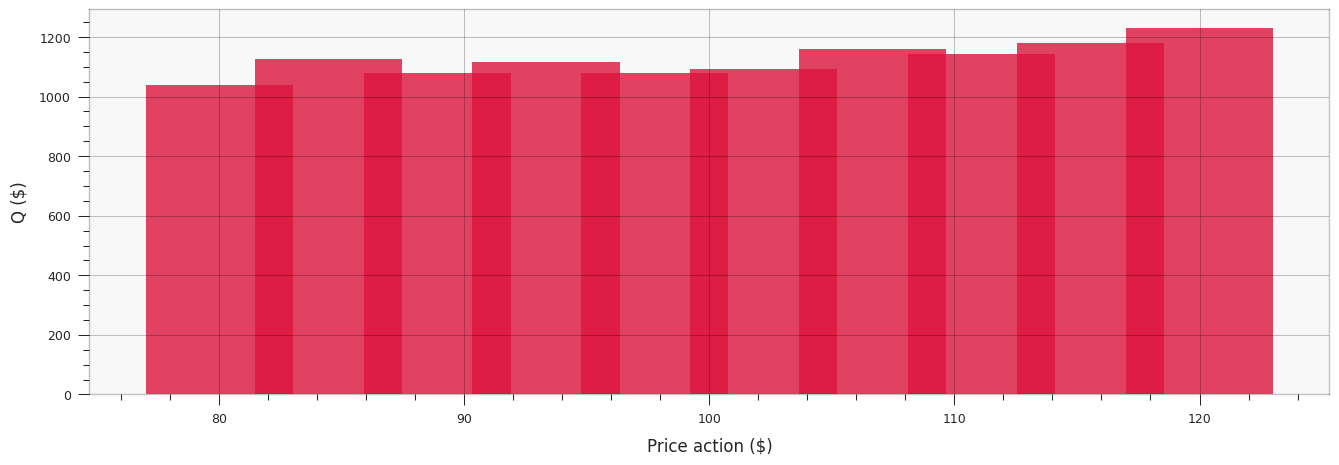

In [ ]:
# Visualize Q-values for a given sample state
sample_state = [170.] + [0.] * (T - 1) + [1.] + [0.] * (T - 1)

# Convert to tensor
Q_s = policy_net(to_tensor(sample_state))

# Identify the best action
a_opt = Q_s.argmax().item()
print(f'Optimal price action: {price_grid[a_opt]}')

# Plot Q-values
plt.figure(figsize=(16, 5))
plt.xlabel("Price action ($)")
plt.ylabel("Q ($)")
plt.bar(price_grid, Q_s.detach().cpu().numpy(), color='crimson', width=6, alpha=0.8)
plt.grid(True)
plt.show()

In [ ]:
# Debugging Q-values computations

transitions = memory.sample(10)
batch = Transition(*zip(*transitions))

non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.stack(batch.reward)

state_action_values = policy_net(state_batch).gather(1, action_batch)

next_state_values = torch.zeros(len(transitions), device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

expected_state_action_values = (next_state_values * GAMMA) + reward_batch[:, 0]

q_trace = []
for t in range(len(transitions)):
    print(f"Q_(s,a)[ {expected_state_action_values[t]} ] = r [ {reward_batch[t].item()} ] + g*Q_(s+1)[ {next_state_values[t]} ]  <> Q_(s,a)[ {state_action_values[t].item()} ]")
    q_trace.append([f"Sample {t}", state_action_values[t].item(), [reward_batch[t].item(), next_state_values[t]]])

Q_(s,a)[ 2695406.75 ] = r [ 0.0 ] + g*Q_(s+1)[ 2695406.75 ]  <> Q_(s,a)[ 2723667.75 ]
Q_(s,a)[ 2236365.75 ] = r [ 0.0 ] + g*Q_(s+1)[ 2236365.75 ]  <> Q_(s,a)[ 2248047.0 ]
Q_(s,a)[ 2326933.25 ] = r [ 0.0 ] + g*Q_(s+1)[ 2326933.25 ]  <> Q_(s,a)[ 2334873.75 ]
Q_(s,a)[ 1821122.5 ] = r [ 0.0 ] + g*Q_(s+1)[ 1821122.5 ]  <> Q_(s,a)[ 1797719.625 ]
Q_(s,a)[ 140863.359375 ] = r [ 140863.359375 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 144011.140625 ]
Q_(s,a)[ 933423.1875 ] = r [ 0.0 ] + g*Q_(s+1)[ 933423.1875 ]  <> Q_(s,a)[ 875683.6875 ]
Q_(s,a)[ 430700.40625 ] = r [ 0.0 ] + g*Q_(s+1)[ 430700.40625 ]  <> Q_(s,a)[ 430757.5625 ]
Q_(s,a)[ 412892.6875 ] = r [ 0.0 ] + g*Q_(s+1)[ 412892.6875 ]  <> Q_(s,a)[ 423423.28125 ]
Q_(s,a)[ 2126182.0 ] = r [ 0.0 ] + g*Q_(s+1)[ 2126182.0 ]  <> Q_(s,a)[ 2002848.25 ]
Q_(s,a)[ 2704170.5 ] = r [ 0.0 ] + g*Q_(s+1)[ 2704170.5 ]  <> Q_(s,a)[ 2742592.5 ]


In [ ]:
import numpy as np
q_trace = [
    [0.5, 0.7, 0.6],  # r, max Q(s',a'), Q(s,a)
    [0.3, 0.4, 0.35],
    [0.6, 0.9, 0.75],
    # ... more rows ...
]

arr = np.array(q_trace, dtype=object)
print(arr.shape)

(3, 3)


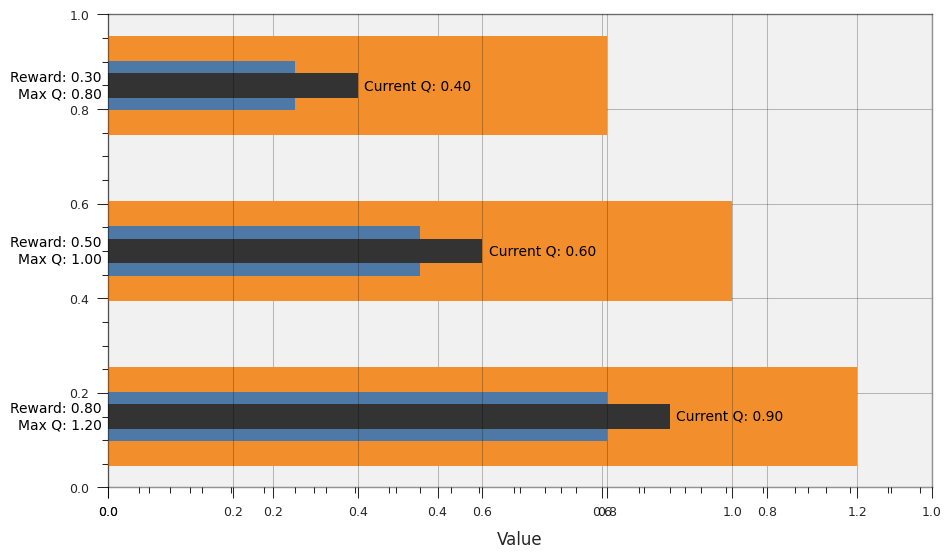

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bullet_graph(data, labels=None, bar_label="", size=(10, 6),
                 axis_label="", label_color="black", bar_color="#333333", palette=None):
    # Convert input to numpy array
    data = np.array(data)
    n = data.shape[0]  # Number of items to plot
    
    # Set default palette if none provided
    if palette is None:
        palette = ["#66c2a5", "#fc8d62"]  # Teal and orange
    
    # Create figure
    fig, ax = plt.subplots(figsize=size)
    
    # Plot each item
    for i in range(n):
        y = n - i - 1  # Position from top to bottom
        
        # Plot max Q value (wide background bar)
        ax.barh(y, data[i, 1], color=palette[1], edgecolor='none', height=0.6)
        
        # Plot reward (medium bar)
        ax.barh(y, data[i, 0], color=palette[0], edgecolor='none', height=0.3)
        
        # Plot current Q value (thin bar)
        ax.barh(y, data[i, 2], color=bar_color, edgecolor='none', height=0.15)
        
        # Add text labels if provided
        if labels:
            ax.text(-0.01, y, 
                   f"{labels[0]}: {data[i,0]:.2f}\n{labels[1]}: {data[i,1]:.2f}",
                   va='center', ha='right', color=label_color, fontsize=10)
        
        # Add current Q value label
        ax.text(data[i, 2]+0.01, y, 
               f"{bar_label}: {data[i,2]:.2f}",
               va='center', ha='left', color=label_color, fontsize=10)
    
    # Format axes
    ax.set_yticks([])
    ax.set_xlabel(axis_label)
    ax.invert_yaxis()  # Top item appears first
    ax.set_xlim(0, np.max(data)+0.1*np.max(data))  # Add 10% padding
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Sample data - each row contains [reward, max_q_value, current_q_value]
    test_data = [
        [0.8, 1.2, 0.9],
        [0.5, 1.0, 0.6],
        [0.3, 0.8, 0.4]
    ]
    
    bullet_graph(test_data,
                labels=["Reward", "Max Q"],
                bar_label="Current Q",
                axis_label="Value",
                palette=["#4e79a7", "#f28e2b"])  # Blue and orange

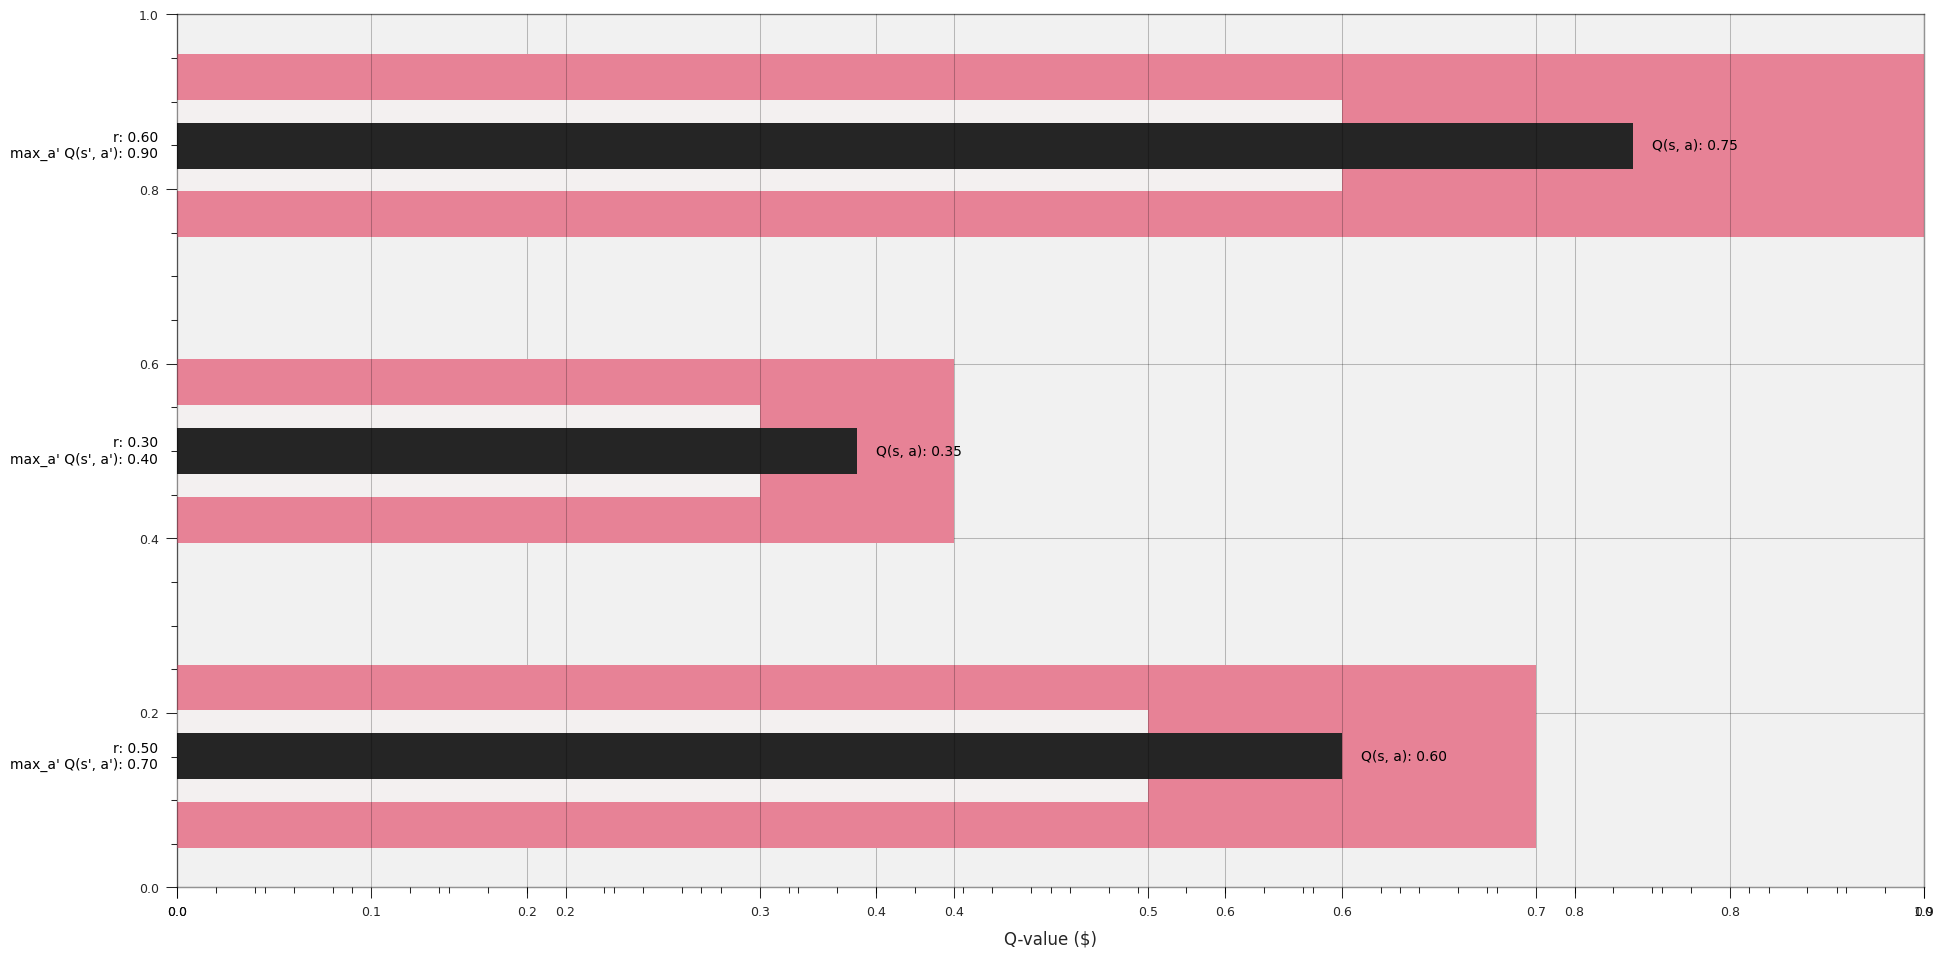

In [ ]:
# Visualization of the debugging infomation for Q-values 
import seaborn as sns
palette = sns.light_palette("crimson", 3, reverse=False)
bullet_graph(np.array(q_trace),
            labels=["r", "max_a' Q(s', a')"], bar_label="Q(s, a)", size=(20, 10),
            axis_label="Q-value ($)", label_color="black",
            bar_color="#252525", palette=palette)

In [16]:
# Playing several episods and recording Q-values with the corresponding actual retunrs

num_episodes = 100
return_trace = []
q_values_rewards_trace = np.zeros((num_episodes, T, 2, ))
for i_episode in range(num_episodes):
    state = env_intial_state()
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state)).detach().numpy()
        action = policy.select_action(q_values)

        next_state, reward = env_step(t, state, action)

        # Move to the next state
        state = next_state

        q_values_rewards_trace[i_episode][t][0] = q_values[action]
        for tau in range(t):
            q_values_rewards_trace[i_episode][tau][1] += reward * (GAMMA ** (t - tau)) 

In [17]:
# Visualizing the distribution of Q-value vs actual returns 

values = np.reshape(q_values_rewards_trace, (num_episodes * T, 2, ))

df = pd.DataFrame(data=values, columns=['Q-value', 'Return'])
g = sns.jointplot(x="Q-value", y="Return", data=df, kind="reg", color="crimson", height=10)
g.plot_joint(plt.scatter, c="k", s=30, linewidth=1, marker="+", alpha=0.4)
g.ax_joint.collections[0].set_alpha(0)  

In [18]:
# Comparing the learning effeciency for different hyperpatarer values
return_trace_gamma_080 = [10, 12, 13, 15, 14, 16, 17, 18, 16, 19, 20, 21, 22, 23, 25]
return_trace_gamma_100 = [8,  9,  11, 13, 12, 14, 15, 17, 16, 17, 18, 19, 20, 21, 22]
# recorded in the Solution section above for gamma=0.80 and gamma=1.00
import pandas as pd
plt.figure(figsize=(16, 5))
plt.xlabel("Episode")
plt.ylabel("Return ($)")
returns_df = pd.Series(return_trace_gamma_080)
ma = returns_df.rolling(window=10).mean()
mstd = returns_df.rolling(window=10).std()
plt.plot(ma, c = 'crimson', alpha = 1.00, linewidth = 1)
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='crimson', alpha=0.2)

returns_df = pd.Series(return_trace_gamma_100)
ma = returns_df.rolling(window=10).mean()
mstd = returns_df.rolling(window=10).std()
plt.plot(ma, c = 'blue', alpha = 0.70, linewidth = 1)
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='blue', alpha=0.15)

plt.legend(["gamma = 0.80", "gamma = 1.00"], loc='lower right', fancybox=False, framealpha=0.6)

## Conclusion générale
✅ Nous avons testé différentes méthodes pour fixer les prix : méthodes simples puis DQN.  
✅ Les graphiques et les résultats montrent que le DQN est plus performant.  
✅ Cette approche peut aider les entreprises à mieux gérer leurs prix pour maximiser leurs profits.

Merci pour votre attention !